## Временные ряды

Давайте посмотрим, как подгонять модель SARIMA(p,d,q)x(P,D,Q) под временной ряд и анализировать качество полученной модели.

In [1]:
# Как обычно, начнем с импорта стандартных библиотек
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import statsmodels.api as sm # все, для работы с рядами
from scipy.special import inv_boxcox # обратное преобразование Бокса-Кокса
from itertools import product # произведения множеств
import warnings # чтобы отключить предупреждения в Python
from google.colab import drive

**Задача.** В файле содержатся данные о месячных приходах статей в научный журнала. Требуется оценить выбрать оптимальную по AIC критерию модель SARIMA и построить прогноз поступлений на следующий год.

In [3]:
drive.mount('/content/gdrive/')
data = pd.read_csv("/content/gdrive/MyDrive/articles.csv",on_bad_lines='skip',sep=";")

data

Mounted at /content/gdrive/


,Data,Count
0,01.01.2019,2
1,01.02.2019,6
2,01.03.2019,7
3,01.04.2019,5
4,01.05.2019,6
5,01.06.2019,6
6,01.07.2019,3
7,01.08.2019,1
8,01.09.2019,1
9,01.10.2019,6


In [4]:
# импортируем данные
# здесь еще мы дополнительно сделали столбец 'month' индексом,
# преобразовали его содержимое в тип "дата" и указали, что у нас американский формат даты (сначала )

data = pd.read_csv("/content/gdrive/MyDrive/articles.csv", sep=';', index_col=['Data'], parse_dates=['Data'], dayfirst=True)

#data

data[data == 0] = 0.1

#data = data[-36:]

data

,Count
Data,
2019-01-01,2.0
2019-02-01,6.0
2019-03-01,7.0
2019-04-01,5.0
2019-05-01,6.0
2019-06-01,6.0
2019-07-01,3.0
2019-08-01,1.0
2019-09-01,1.0


### 1. Визуальный анализ и предобработка

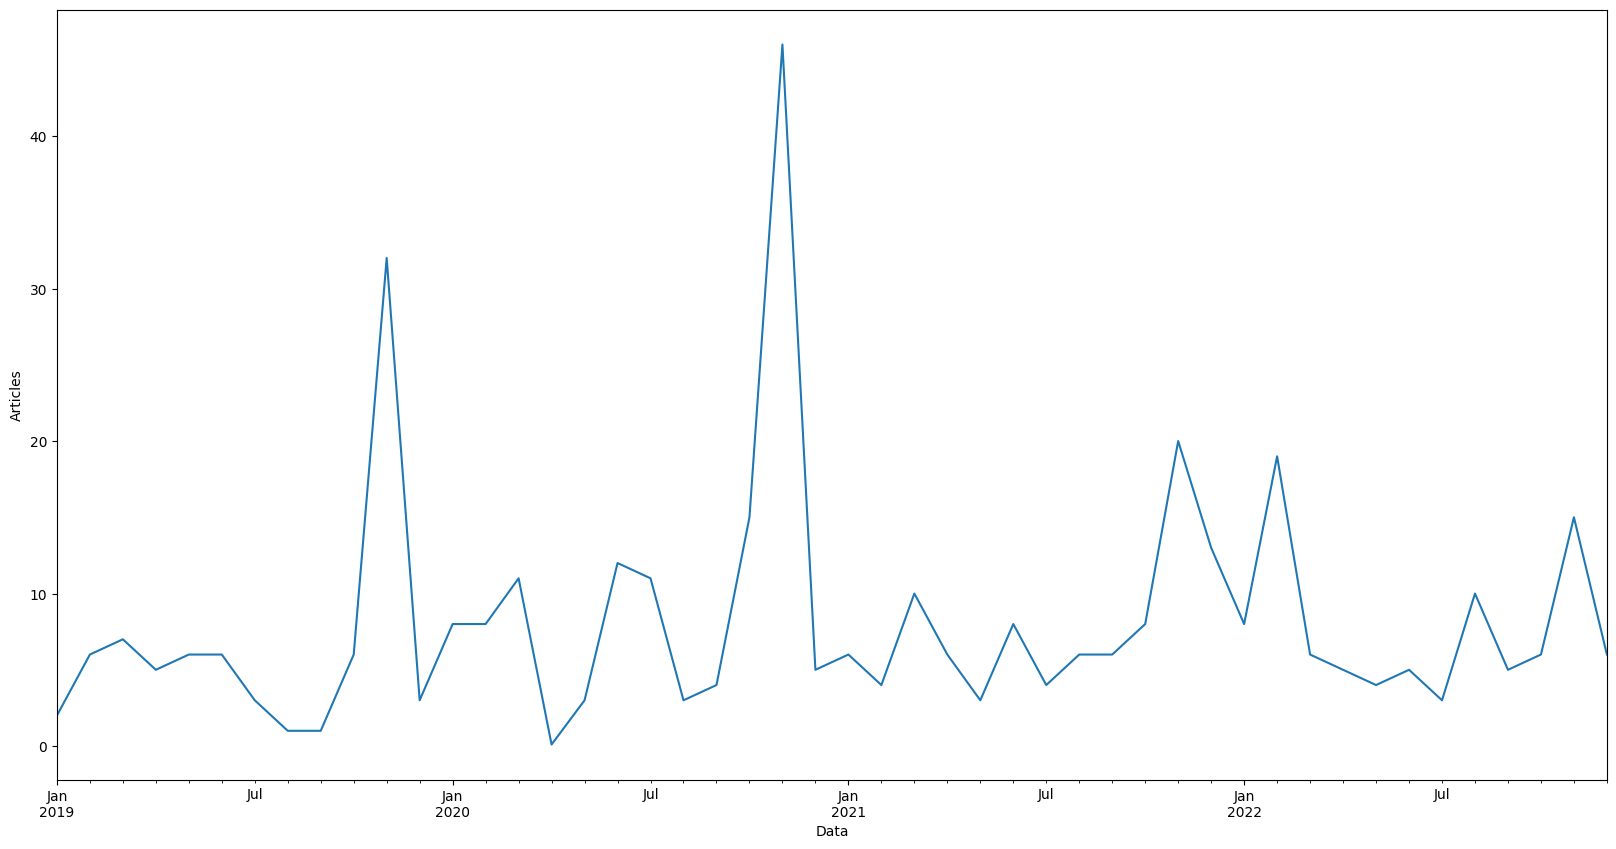

In [5]:
plt.figure(figsize=(20,10))
data.Count.plot()
plt.ylabel('Articles')
plt.show()

Мы видим, что временной ряд не содержит пропуски. Начало ряда не сильно отличается от конца ряда, поэтому мы ничего удалять не будем. У ряда видна очевидная годовая сезонность (больше всего вина продается в декабре, меньше всего — в январе). Кроме этого, есть возможный цикл или меняющийся тренд. Наконец, дисперсия ряда увеличивается со временем.  

Удобный инструмент для визуального анализа ряда — его **STL-декомпозиция**. STL расшифровывается как A Seasonal-Trend Decomposition Procedure Based on Loess, и это процедура декомпозиции временного ряда на сезонную, трендовую составляющие и на остатки, использующую метод локальных регрессий (LOESS). И именно с помощью LOESS и происходит сглаживание исходного ряда данных.

<Figure size 1600x800 with 0 Axes>

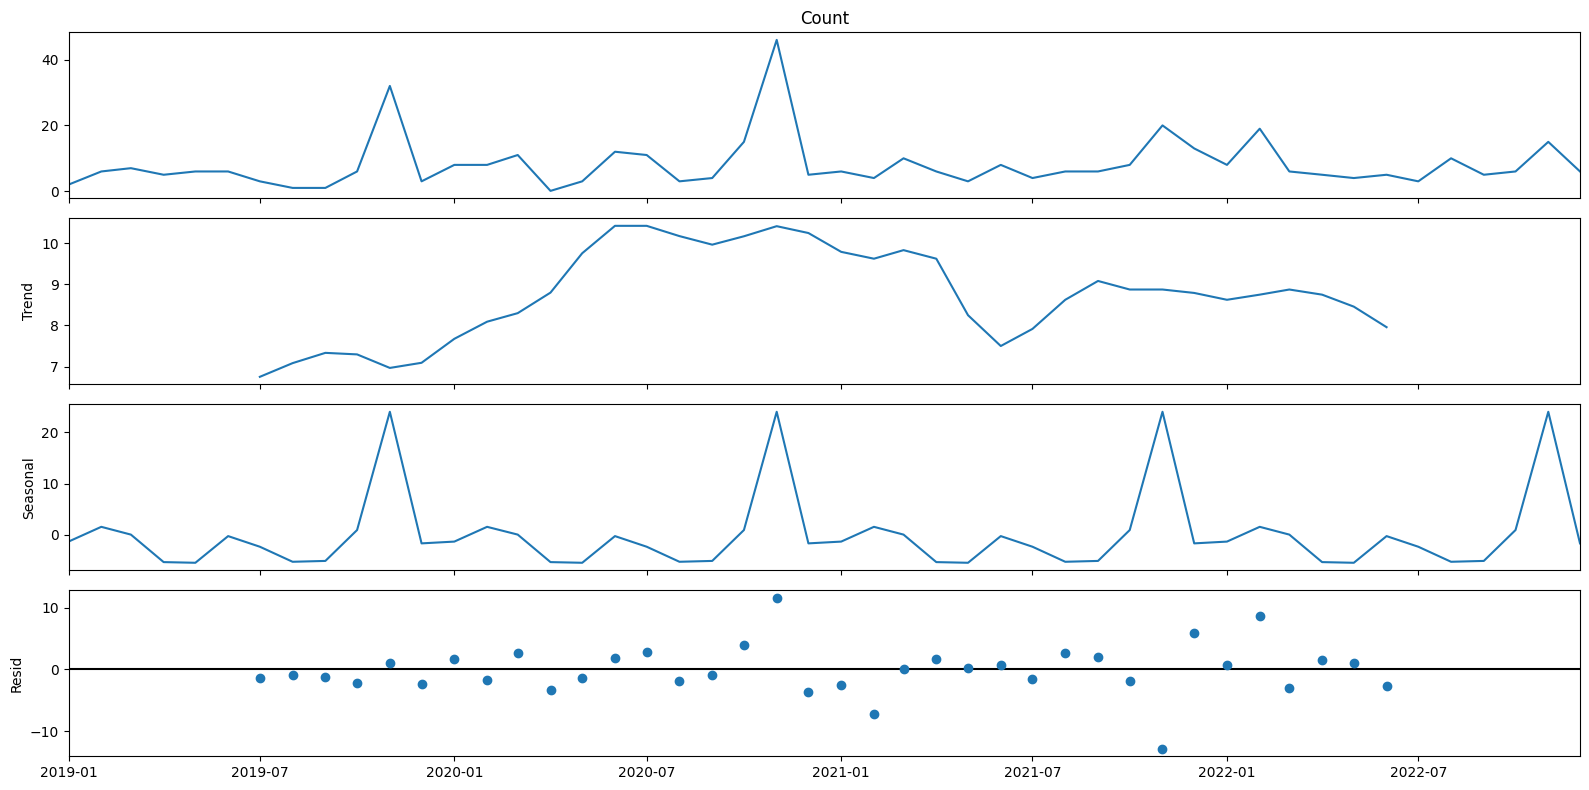

In [6]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.Count).plot()
plt.show()

### 2. Стабилизация дисперсии

Стабилизировать дисперсию мы будем с помощью преобразованися Бокса-Кокса. В Python реализовано это преобразование с автоматическим подбором параметра $\lambda$. Им мы и воспользуемся. Преобразованный ряд запишем в тот же DataFrame.

In [7]:
data['sales_boxcox'], lmbd = stats.boxcox(data['Count'])

In [8]:
print("Оптимальный параметр преобразования Бокса-Кокса: ",lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  0.24247981531578094


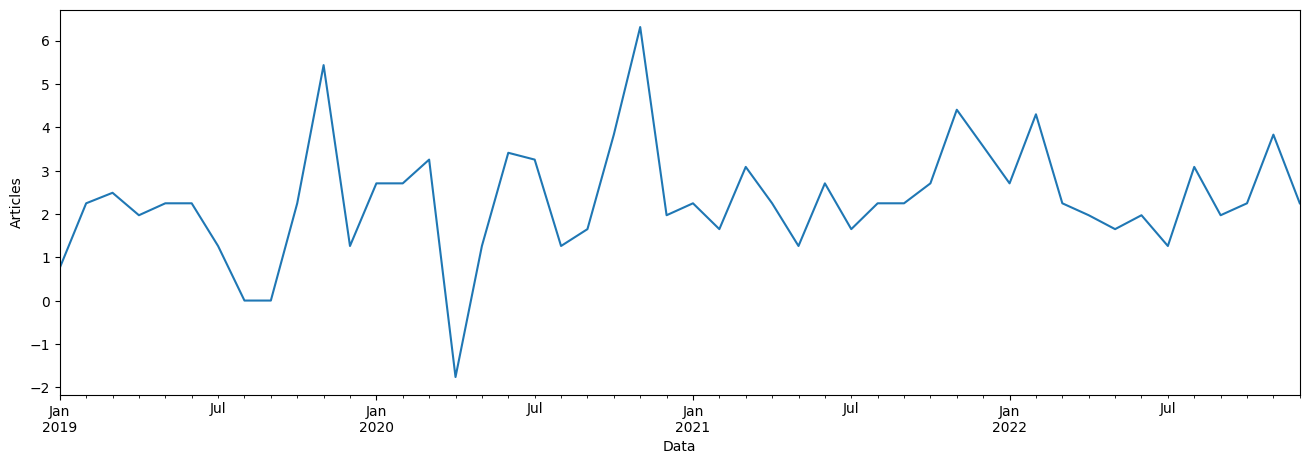

In [9]:
plt.figure(figsize(16,5))
data.sales_boxcox.plot()
plt.ylabel('Articles')
plt.show()

После преобразования Бокса-Кокса дисперсия ряда стала более стабильной. Посмотрим на STL-декомпозицию преобразованного ряда.

<Figure size 1600x800 with 0 Axes>

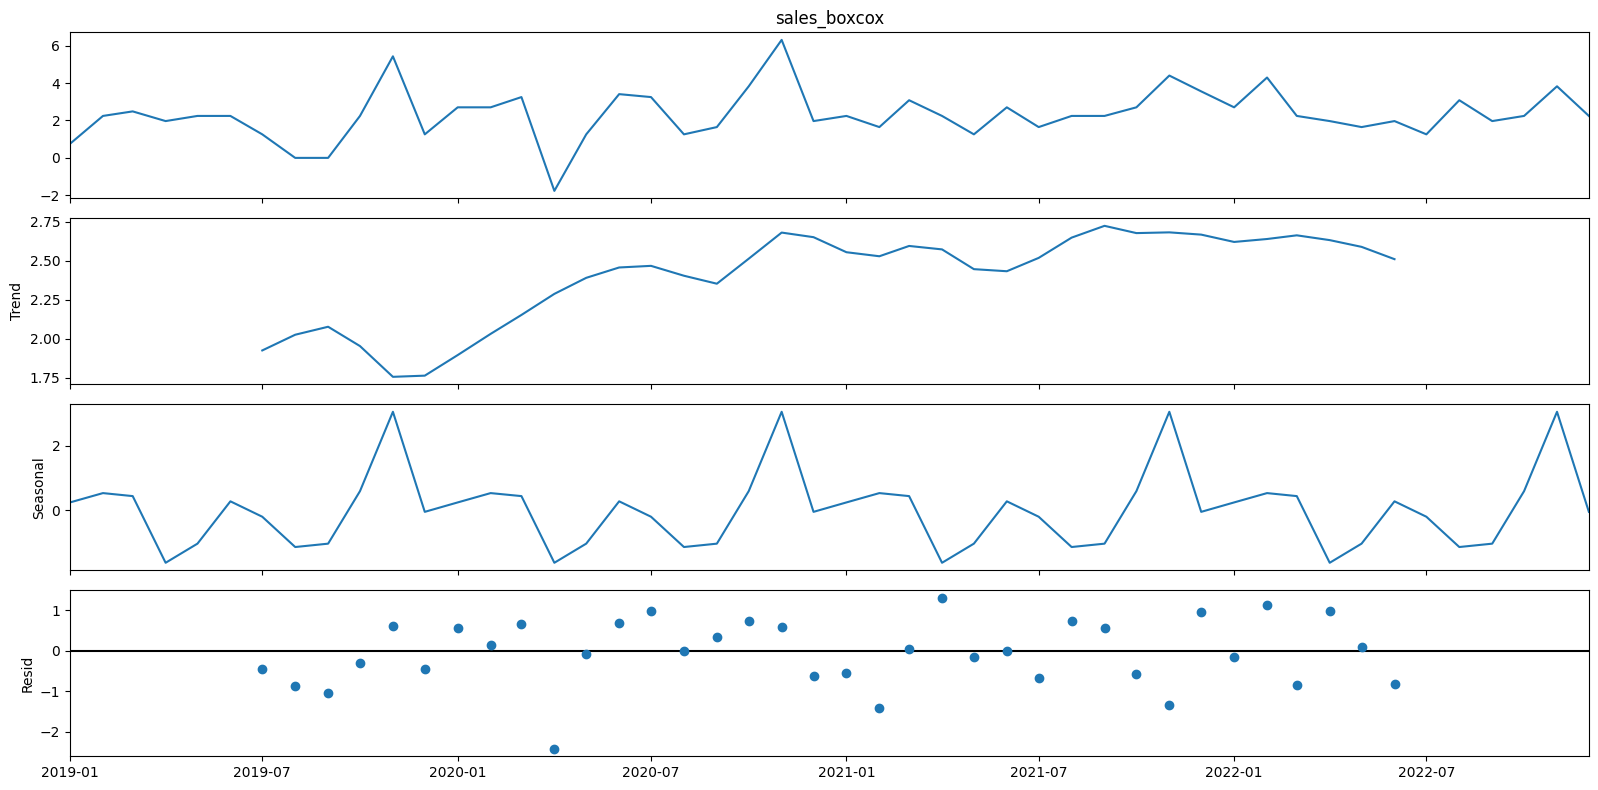

In [10]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.sales_boxcox).plot()
plt.show()

### 3. Дифференцирование

По построенным графикам видно, что данные обладают сезонностью и, возможно, трендом, который необходимо удалить. Этот шаг необходим, чтобы сделать ряд стационарным и подогнать к нему модель SARMA (у нас есть гарантии, что эта модель хорошо описывает только стационарные ряды). Как было сказано на лекции: лучше всего начинать с сезонного дифференцирования.

In [11]:
data['sales_boxcox_diff'] = data.sales_boxcox - data.sales_boxcox.shift(12)

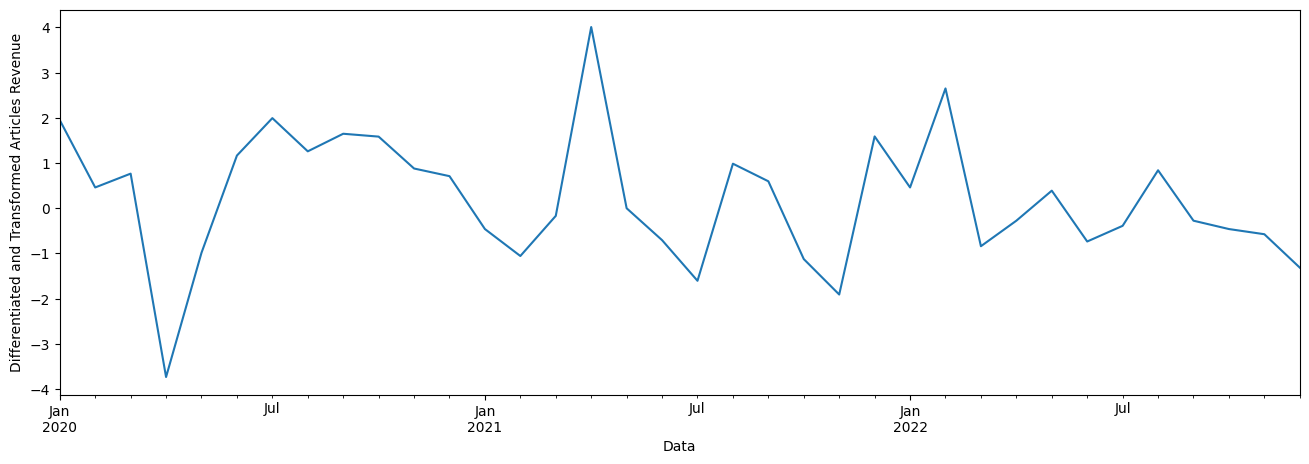

In [12]:
plt.figure(figsize(16,5))
data.sales_boxcox_diff[12:].plot()
plt.ylabel('Differentiated and Transformed Articles Revenue')
plt.show()

<Figure size 1600x800 with 0 Axes>

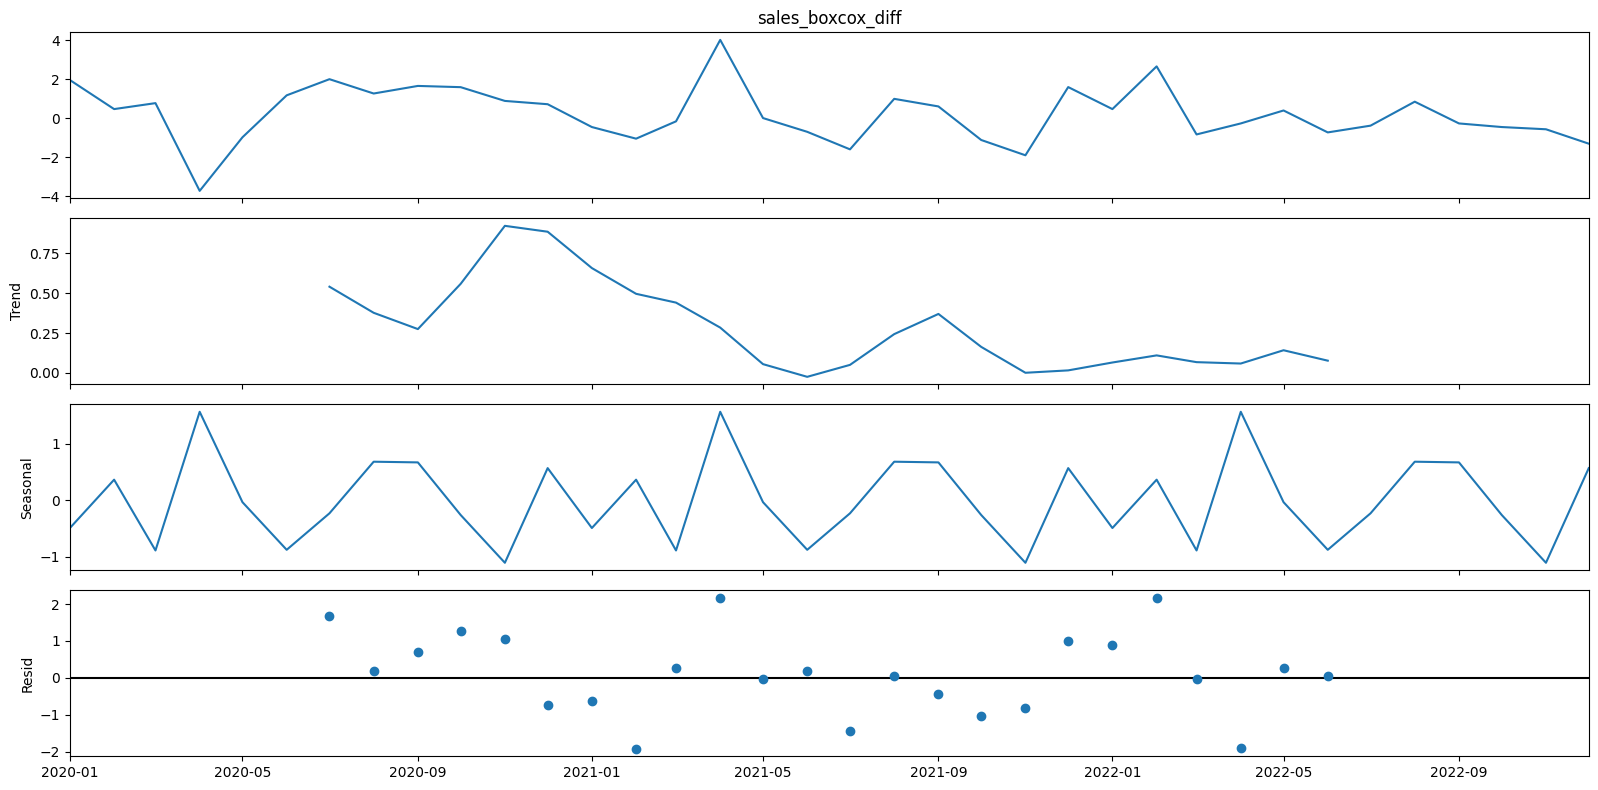

In [13]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.sales_boxcox_diff[12:]).plot()
plt.show()

Видим, что после сезонного дифференцирования пропала только сезонность, но ряд не стал стационарным  (например, потому что у него есть заметный тренд). Сделаем еще одно обычное дифференцирование.

In [14]:
data['sales_boxcox_diff2'] = data.sales_boxcox_diff - data.sales_boxcox_diff.shift(1)

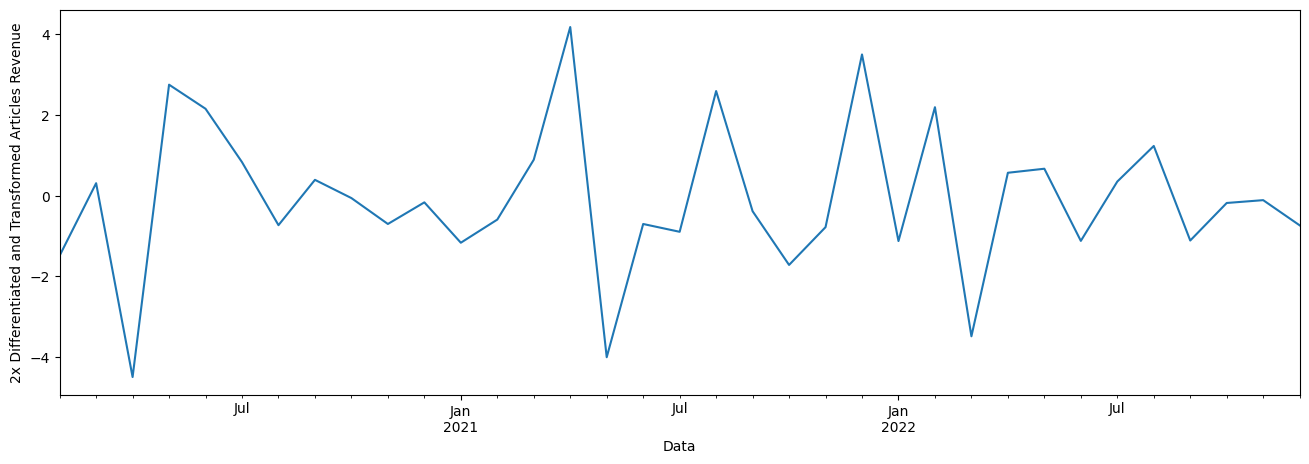

In [15]:
plt.figure(figsize(16,5))
data.sales_boxcox_diff2[13:].plot()
plt.ylabel('2x Differentiated and Transformed Articles Revenue')
plt.show()

In [16]:
#plt.figure(figsize(16,8))
#sm.tsa.seasonal_decompose(data.sales_boxcox_diff2[13:]).plot()
#plt.show()

Теперь наш ряд стал похож на стационарный. Попробуем формально отвергнуть гипотезу о нестационарности с помощью критерия Дики-Фуллера.

In [17]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",sm.tsa.stattools.adfuller(data.sales_boxcox_diff2[13:])[1])

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 0.0022524163418351983


Гипотеза о нестационарности уверенно отвергается. Для эксперимента проверим с помощью этого критерия еще начальный ряд и ряд после преобразования Бокса-Кокса.

In [18]:
print("Критерий Дики-Фуллера для начального ряда: pvalue =",sm.tsa.stattools.adfuller(data.Count)[1])

Критерий Дики-Фуллера для начального ряда: pvalue = 2.4004898764311557e-08


In [19]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",sm.tsa.stattools.adfuller(data.sales_boxcox_diff[12:])[1])

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 0.0001362668754915596


Видим, что для начального ряда гипотеза о нестационарности отвергается на уровне 6%. Это означает, что данный критерий не являются универсальным и всегда работающим. Поэтому нужно всегда оценивать свои выводы по графикам.

### 4. Выбор начальных значений для $p,q$ и $P,Q$.

Чтобы выбрать начальные значения для $p,q$ и $P,Q$, необходимо построить графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF).

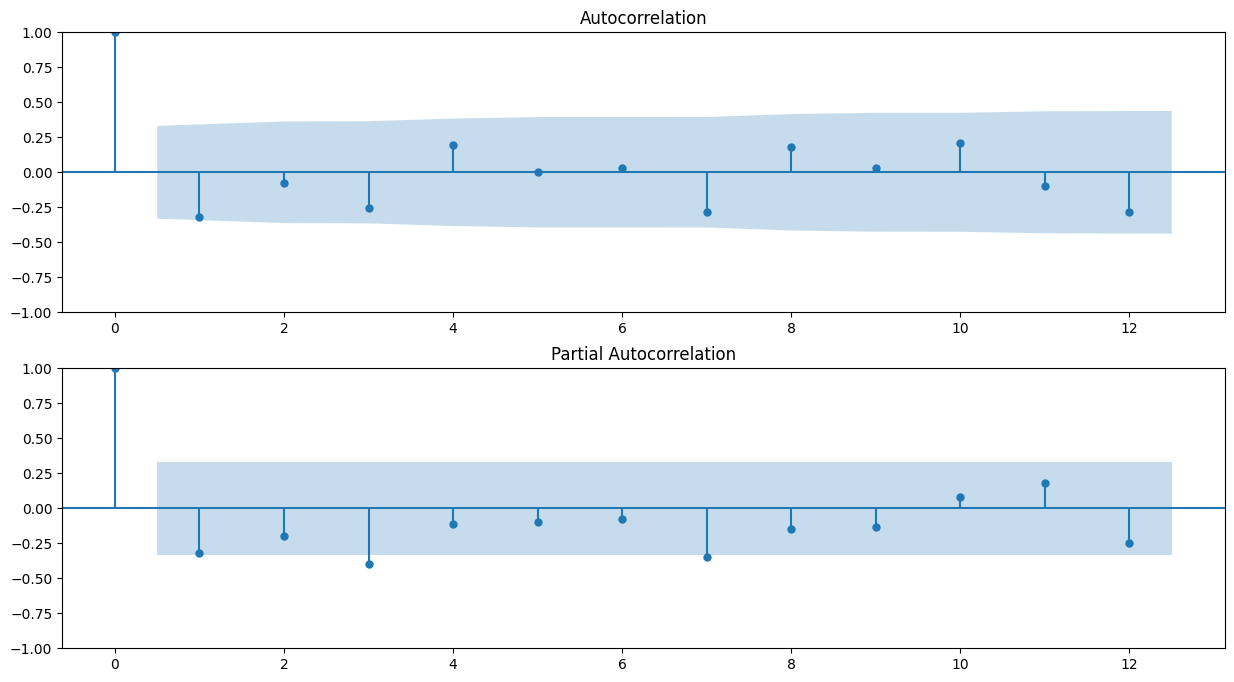

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8))

sm.graphics.tsa.plot_acf(data.sales_boxcox_diff2[13:].values.squeeze(), lags=12, ax=ax1)
sm.graphics.tsa.plot_pacf(data.sales_boxcox_diff2[13:].values.squeeze(), lags=12, ax=ax2)

plt.show()

Согласно этим графикам, в качестве начальных значений необходимо взять: $Q=1$, $q=2$, $P=2$, $p=4$.

### 5. Перебор и сравнение моделей для всех $p,q$ и $P,Q$, которые меньше или равны начальным значениям

In [21]:
# создадим список из значений параметров для перебора моделей


d=D= 1
ps = range(0, 5)
qs = range(0, 3)
Ps = range(0, 3)
Qs = range(0, 2)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

In [22]:
# посмотрим, сколько моделей нам предстоит обучить

len(parameters_list)

90

In [23]:
results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in parameters_list:
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.sales_boxcox, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)

    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue

    results.append([param, model.aic])

In [24]:
# преобразуем результаты в DataFrame и добавим названия столбцов

result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']

In [25]:
# выведем 5 лучших по AIC моделей

result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
7,"(0, 1, 0, 1)",127.914400
64,"(3, 1, 2, 0)",128.021756
70,"(3, 2, 2, 0)",128.661659
67,"(3, 2, 0, 1)",128.784357
61,"(3, 1, 0, 1)",129.126794


Лучшей моделью получилась SARIMA (2,1,1)x(0,1,1). Именно на ней мы и остановимся. Заметим, что следующие по AIC модели имеют больше параметров, а чем больше параметров у модели — тем более она неустойчива и тем хуже ее вероятностные свойства. Поэтому иногда, если AIC у двух моделей отличается незначительно, то отдать предпочтение нужно той, которая содержит меньше параметров. Так, иногда, стоит выбирать модели, которые находятся на 2-3 месте.

In [26]:
best_model=sm.tsa.statespace.SARIMAX(data.sales_boxcox, order=(0,1,1), seasonal_order=(0,1,1,12)).fit(disp=-1)

In [27]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       sales_boxcox   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -60.957
Date:                            Sun, 15 Oct 2023   AIC                            127.914
Time:                                    16:07:35   BIC                            132.580
Sample:                                01-01-2019   HQIC                           129.525
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9583      0.374     -2.564      0.010      -1.691      -0.226
ma.S.L12      -0.6701      0.477   

### 6. Анализ остатков

Чтобы убедится, что модель хорошая, осталось проанализировать остатки. Сначала посмотрим на них.

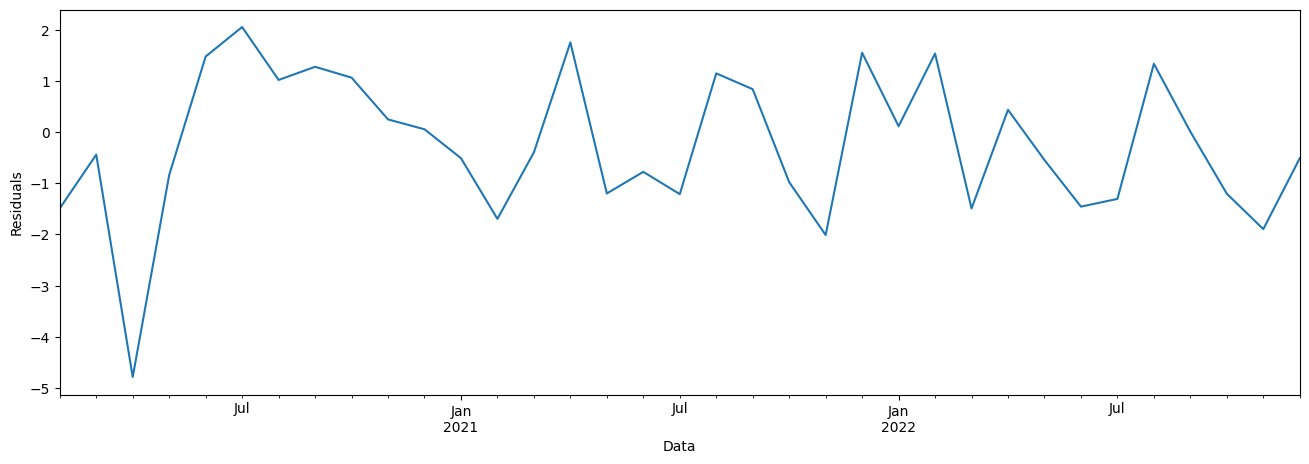

In [28]:
plt.figure(figsize(16,5))
best_model.resid[13:].plot()
plt.ylabel('Residuals')
plt.show()

Визуально остатки выглядят хорошо. Не видны признаки смещенности, нестационарности или какой-либо зависимости.

**Несмещенность.** Проверим несмещенность с помощью критерия знаков (самый универсальный критерий).

In [29]:
from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =",sign_test(best_model.resid[13:])[1])

Критерий знаков для остатков: pvalue = 0.735878800856881


**Стационарность.** Проверим стационарность с помщью критерия Дики-Фуллера.

In [30]:
print("Критерий Дики-Фуллера для остатков: pvalue =",sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 1.2165018934063276e-05


**Неавтокоррелированность.** Чтобы определить независимость остаткок, посмотрим на график автокорреляционной функции.

<Figure size 1600x500 with 0 Axes>

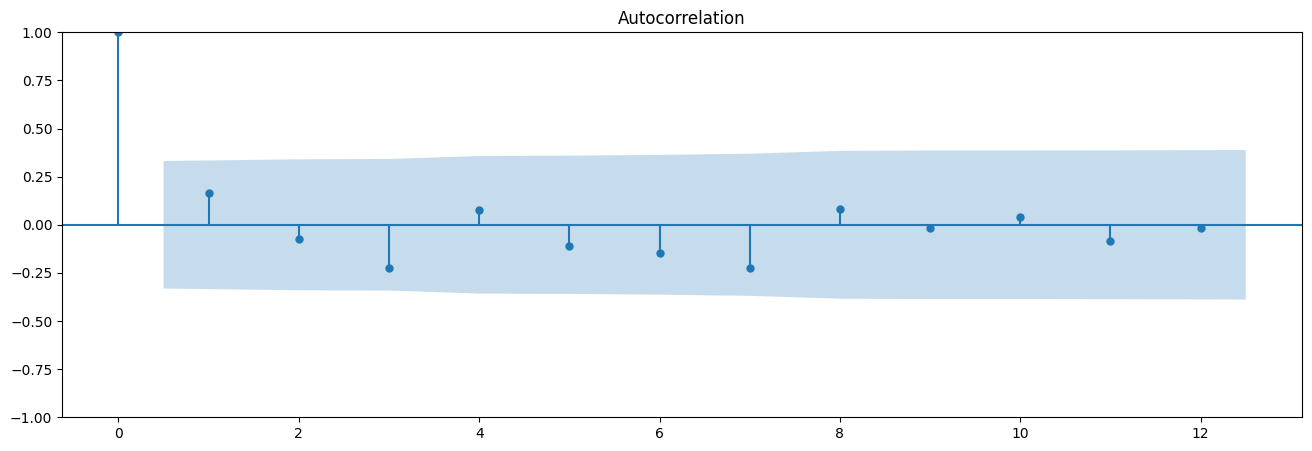

In [31]:
plt.figure(figsize(16,5))
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=12)
plt.show()

Еще обратим внимание, что в summary содержалась информация о Q-критерии Льюнга-Бокса. Этот тест не отвергает нулевую гипотезу о независимости остатков.

### График модель + ряд

Выведем на графике наш ряд и построенную для него модель. Для этого необходимо сделать обратное преобразование Бокса.

In [32]:
# сохраним значения нашей модели (не забудем сделать обратное преобразование Бокса-Кокса)

data['model'] = inv_boxcox(best_model.fittedvalues, lmbd)

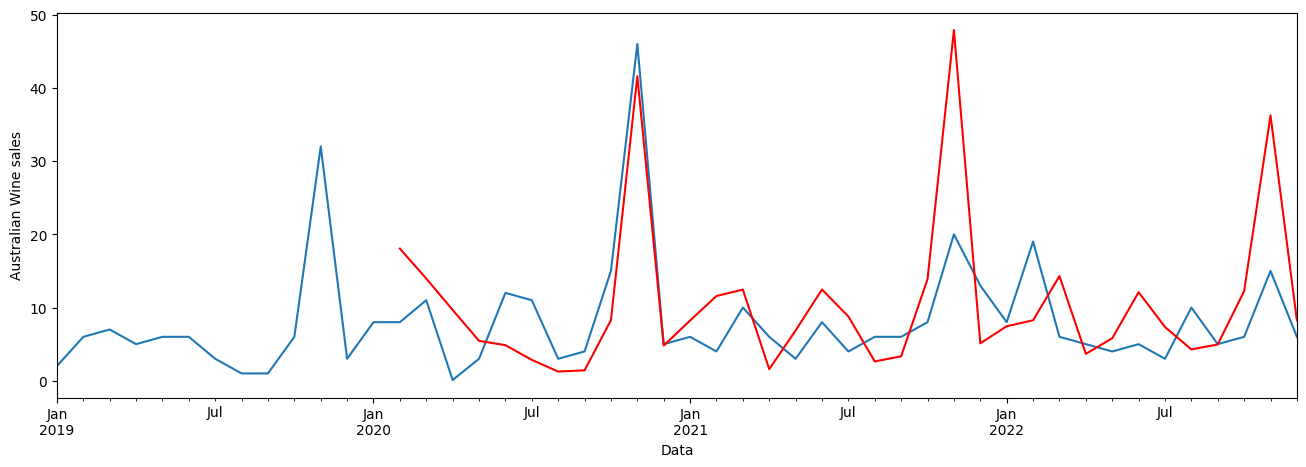

In [33]:
plt.figure(figsize(16,5))
data.Count.plot()
data.model[13:].plot(color='r')
plt.ylabel('Australian Wine sales')
pylab.show()

### Прогноз

Чтобы сделать прогноз, необходимо воспользоваться функцией predict. Так как у DataFrame индексами являются даты, нам необходимо еще записать даты для прогноза. Будем хранить значения ряда и прогноза в new_data.

In [34]:
# сделаем подготовительную работу

plot_data = data[['Count','model']]

date_list = [datetime.datetime.strptime("2023-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= plot_data.columns)
plot_data = pd.concat([plot_data, future])

date_list

[datetime.datetime(2023, 1, 1, 0, 0),
 datetime.datetime(2023, 2, 1, 0, 0),
 datetime.datetime(2023, 3, 1, 0, 0),
 datetime.datetime(2023, 4, 1, 0, 0),
 datetime.datetime(2023, 5, 1, 0, 0),
 datetime.datetime(2023, 6, 1, 0, 0),
 datetime.datetime(2023, 7, 1, 0, 0),
 datetime.datetime(2023, 8, 1, 0, 0),
 datetime.datetime(2023, 9, 1, 0, 0),
 datetime.datetime(2023, 10, 1, 0, 0),
 datetime.datetime(2023, 11, 1, 0, 0),
 datetime.datetime(2023, 12, 1, 0, 0)]

In [35]:
# построим предсказание, сделаем для него обратное преобразование Бокса-Кокса

forecast = inv_boxcox(best_model.predict(start=48, end=48+11), lmbd)
forecast.index = date_list

In [36]:
# запишем его в столбец Model

plot_data.loc[date_list, 'model'] = forecast

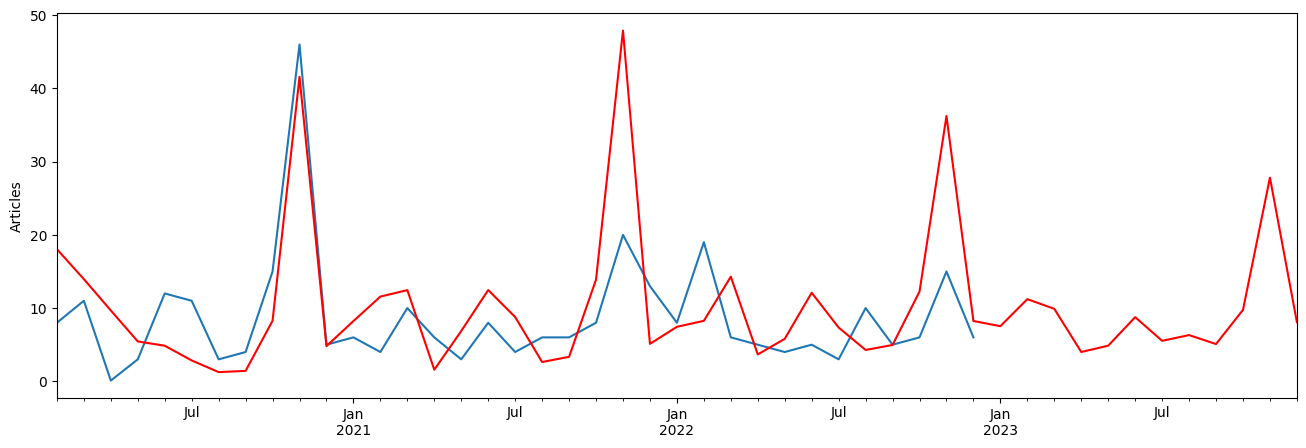

2023-01-01     8.0
2023-02-01    11.0
2023-03-01    10.0
2023-04-01     4.0
2023-05-01     5.0
2023-06-01     9.0
2023-07-01     6.0
2023-08-01     6.0
2023-09-01     5.0
2023-10-01    10.0
2023-11-01    28.0
2023-12-01     8.0
Name: model, dtype: float64

In [37]:
plt.figure(figsize(16,5))
plot_data.Count[13:].plot()
plot_data.model[13:].plot(color='r')
plt.ylabel('Articles')
pylab.show()

data.model

round(plot_data.model[-12:],0)


In [38]:
data

,Count,sales_boxcox,sales_boxcox_diff,sales_boxcox_diff2,model
Data,,,,,
2019-01-01,2.0,0.754803,NaN,NaN,1.000000
2019-02-01,6.0,2.244053,NaN,NaN,1.999999
2019-03-01,7.0,2.486587,NaN,NaN,5.999988
2019-04-01,5.0,1.968656,NaN,NaN,6.999998
2019-05-01,6.0,2.244053,NaN,NaN,5.000004
2019-06-01,6.0,2.244053,NaN,NaN,5.999998
2019-07-01,3.0,1.258850,NaN,NaN,6.000000
2019-08-01,1.0,0.000000,NaN,NaN,3.000005
2019-09-01,1.0,0.000000,NaN,NaN,1.000003
